In [1]:
import numpy as np
from PIL import Image
import rasterio
import rasterio.mask
from rasterio.plot import show
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt

In [33]:
scenario_path = 'data/Mflood1_grotekans/MaximaleWaterdiepteNederland_Kaart1.tif'
scenario_folders = [
    'data/Mflood1_grotekans/MaximaleWaterdiepteNederland_Kaart1.tif',
    'data/Mflood2_middelgrotekans/MaximaleWaterdiepteNederland_Kaart2.tif',
    'data/Mflood3_kleinekans/MaximaleWaterdiepteNederland_Kaart3.tif',
    'data/Mflood4_zeerkleinkans/MaximaleWaterdiepteNederland_Kaart4.tif',
    'data/Mflood5_extreemkleinekans/MaximaleWaterdiepteNederland_Kaart5.tif']
nl_path = 'data/top1000raster-geotiff-landsdekkend/TOP1000raster_GEOTIFF_april_2022/TOP1000raster_GEOTIFF/TOP1000raster-Nederland-2020-2021.tif'
# with rasterio.open(scenario_path) as NL_map:
flood_maps = [rasterio.open(path) for path in scenario_folders]
flood_map = rasterio.open(scenario_path)
wijken = gpd.read_file('data/wijk_geometries.shp')

# load large rdam DTM into memory
rdam_dtm_map = rasterio.open('data/rdam_topo_map.tif',mode='r')


# Merge DTM tiles into one image (one-time item, reactivate whenever necessary)
Procedure:
1. Retrieve all items from directory to be merged with
2. Open all items into list
3. Use rasterio.merge to save all into TIFF image for future use

In [32]:
import rasterio.merge # ad hoc import
# sanity check for tiff format

path = 'data/DSMs/'
dtm_files = [f for f in os.listdir(path) if '.tif' in f.lower()]
# load into list for now
dtm_list = [rasterio.open(f'{path}{name}') for name in dtm_files]

mosaic, mosaic_trans = rasterio.merge.merge(dtm_list)
f32_inf = 340282346638528859811704183484516925440.00000
# mosaic[mosaic == f32_inf] = np.nan # ALERT: not necessary!

show(mosaic, transform=mosaic_trans)
# Save merged map as TIF image (for further reuse), one-time
with rasterio.open('data/rdam_topo_map.tif',mode='w',count=1,
                   width=mosaic.squeeze().shape[1],
                   height=mosaic.squeeze().shape[0],
                   crs=dtm_list[0].crs,
                   transform=mosaic_trans,
                   dtype=dtm_list[0].dtypes[0]) as dest:
    dest.write(mosaic)

<AxesSubplot:>

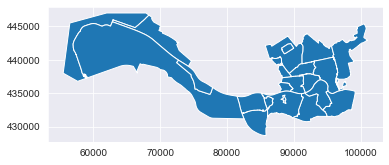

In [19]:
# get geometries of water
wijken_2 = gpd.read_file('data/WijkBuurtkaart_2020_v2/wijk_2020_v2.shp')
wijken_2 = wijken_2[wijken_2.GM_CODE=='GM0599']
wijken_2.plot()

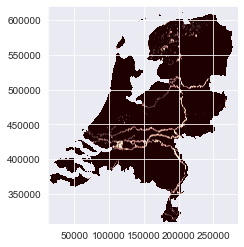

<AxesSubplot:>

In [3]:
show(flood_map.read(1), cmap='pink', transform=flood_map.transform)


In [9]:
"""
Mask using shapefile
"""
overwrite = True # set to overwrite
# rdam_buurten = None
# rdam_geometries = None
if 'rdam_buurten' not in locals() or overwrite:
    rdam_buurten = gpd.read_file('data/Rdam_buurten_shape.shp')
    rdam_geometries = rdam_buurten.geometry.to_list()

# rdam_map,rdam_transform = rasterio.mask.mask(nl_map, rdam_geometries,crop=True)
# rdam_floodmap, rdam_floodtransform = rasterio.mask.mask(flood_map, rdam_geometries, crop=True)

In [5]:
# create container of cut flood maps per wijk, per flood map.
# dict? flattened
# need to create labels
wijk_names = wijken.WK_NAAM.str.replace(' ','-').to_list()
wijk_geometries = wijken.geometry

labels = []
scenarios = []
for idx, wijk in enumerate(wijk_names):
    geo = wijk_geometries[idx]
    labels.extend(['_'.join([str(number),wijk]) for number,_ in enumerate(flood_maps)])
    scenarios.extend([rasterio.mask.mask(f_m, [geo], crop=True, nodata=np.nan) for f_m in flood_maps])

# need some sort of linkage to dict, and to merge together for large image?



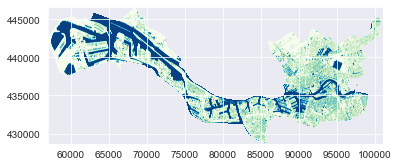

In [35]:
rdam_map, rdam_transform = rasterio.mask.mask(rdam_dtm_map, rdam_geometries, crop=True, nodata=np.nan)
# create rdam map:
fig, ax = plt.subplots()
show(rdam_map,cmap='GnBu', transform=rdam_transform,ax=ax)
plt.savefig('data/rdam_map.jpg', dpi=800)

'\nnote that some areas are covered in -9999 suggesting these are water areas?\nprolly need to save the stuff as numpy array instead of tiff again\nnow have a location of 723x1763 pixels (need to see how it scales)\n'

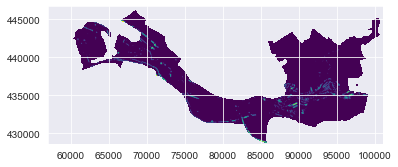

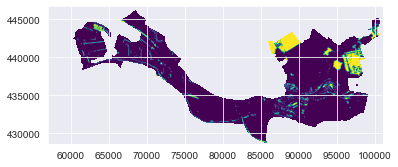

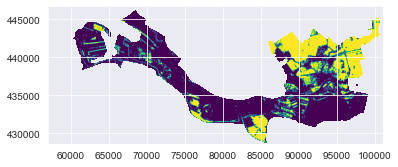

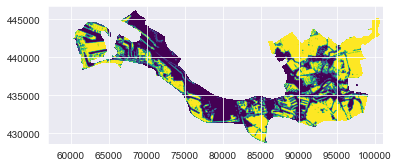

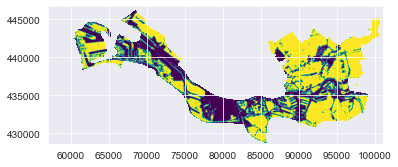

In [7]:
counter = 1
for scenario, transform in rdam_scenarios:
    fig, ax = plt.subplots()
    # print(scenario.squeeze())
    # plt.imshow(scenario.squeeze()) # squeeze reduces dimensions of 1
    show(scenario,cmap='viridis', transform=transform, ax=ax)
    plt.savefig(f'data/flood_scenario_{counter}.png', dpi=800)
    counter += 1
"""
note that some areas are covered in -9999 suggesting these are water areas?
prolly need to save the stuff as numpy array instead of tiff again
now have a location of 723x1763 pixels (need to see how it scales)
"""

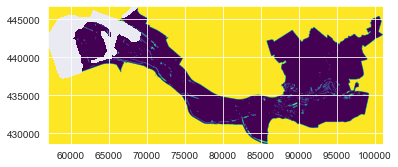

<AxesSubplot:>

In [9]:
show(rdam_floodmap,cmap='viridis',transform=rdam_floodtransform)

Need to find proportion of flood-vulnerable tiles (severity vs risk in the wijk) per wijk
- gotten the spatial merge dataset (need to merge into one set, and also cut out for Rdam)
- get total non-0 space (area) and count distribution of flooded areas (in bins of cm?)
-

In [10]:
"""
(DEPRECIATED)
Derive the bounding box of R'dam city area.
This was done via visual reference wrt. EPSG.io
Coordinates are lat and lon respectively
"""
lats_n_lons = np.array([[100714.29, 445630.69], # TR
                    [98741.08, 435823.16], # BR
                    [92577.37, 430378.59], # BCentre
                    [86869.55, 431585.33], # BL
                    [84677.32, 443843.01], # TL
                    [91726.67, 445371.99]]) # TCentre
max_latslons = np.nanmax(lats_n_lons,axis=0)
min_latslons = np.nanmin(lats_n_lons,axis=0)
lats = (min_latslons[0],max_latslons[0])
lons = (min_latslons[1],max_latslons[1])
